In [ ]:
%%capture
!pip install datasets
!pip install transformers

In [ ]:
import re
import string
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
import random
import torch
import torch.nn as nn
import datasets
from datasets import load_dataset,DatasetDict
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification, AutoModel, DataCollatorWithPadding, AutoModelForSequenceClassification, AutoConfig
from transformers import TrainingArguments, Trainer, AutoModelForPreTraining
import time
import copy
from tqdm.auto import tqdm

torch.manual_seed(10)

In [ ]:
dml = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dml

device(type='cuda', index=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read data from file

In [ ]:
PATH = '/content/drive/MyDrive/Dataset/dataset.csv'
dataSet = pd.read_csv(PATH)
print(dataSet.shape)
dataSet.head(10)

(4003, 2)


,text,label
0,যেমনটা আশা করছিলাম তেমনটাই দিয়েছেন,2
1,এক দোম ফালতু কেও নিবেন না,0
2,আলহামদুলিল্লাহ ভালো প্রডাক্ট এবং ভালো ভাবে পেয়...,1
3,আমার কাছে অসম্ভব সুন্দর লাগছে ছবির তুলনায় বাস্...,1
4,খুবই চমৎকার একটা ঘড়ি। ধন্যবাদ,2
5,অনেক সুন্দর চোখ বুঝে নিতে পারেন,2
6,আপনারা নিশ্চিন্তে নিতে পারেন অনেক ভালো একটি প্...,2
7,কথায় আর কাজে ঠিক আছে,1
8,এতো দামি ঘরি একটা ভালো প্যাকেট দেয় নায়,1
9,আমি যেমন চেয়েছিলাম তেমোন পাইনি,0


# Drop duplicate value

In [ ]:
print(dataSet.shape)
dataSet = dataSet.drop_duplicates(subset=['text'])
print(dataSet.shape)

(4003, 2)
(3268, 2)


In [ ]:
dataSet = dataSet.reset_index()

# Preprocessing

In [ ]:
def remove_urls(phrase):
    return re.sub(r"http(s?)://[\S]+", '', phrase)

def remove_at_links(phrase):
    return re.sub(r"\B(@)\S+", '', phrase)

def fix_special_chars(phrase):
    phrase = phrase.replace("&amp;", " ")
    phrase = phrase.replace("\n", " ")
    return phrase

def remove_emoji(phrase):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', phrase)

def remove_punctuation(phrase):
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~।,;:?!\'."-[]{}()–—―~'''
    for ele in phrase:
        if ele in punc:
            phrase = phrase.replace(ele, " ")
    return phrase

def clean_phrase(phrase):
    phrase = remove_punctuation(phrase)
    phrase = remove_urls(phrase)
    phrase = remove_at_links(phrase)
    phrase = fix_special_chars(phrase)
    phrase = remove_emoji(phrase)

    return phrase

In [ ]:
lst = [clean_phrase(phrase) for phrase in dataSet['text']]
dataSet['text_cleaned'] = lst
dataSet.head()

,index,text,label,text_cleaned
0,0,যেমনটা আশা করছিলাম তেমনটাই দিয়েছেন,2,যেমনটা আশা করছিলাম তেমনটাই দিয়েছেন
1,1,এক দোম ফালতু কেও নিবেন না,0,এক দোম ফালতু কেও নিবেন না
2,2,আলহামদুলিল্লাহ ভালো প্রডাক্ট এবং ভালো ভাবে পেয়...,1,আলহামদুলিল্লাহ ভালো প্রডাক্ট এবং ভালো ভাবে পেয়...
3,3,আমার কাছে অসম্ভব সুন্দর লাগছে ছবির তুলনায় বাস্...,1,আমার কাছে অসম্ভব সুন্দর লাগছে ছবির তুলনায় বাস্...
4,4,খুবই চমৎকার একটা ঘড়ি। ধন্যবাদ,2,খুবই চমৎকার একটা ঘড়ি ধন্যবাদ


In [ ]:
dataSet.isnull().sum()

index           0
text            0
label           0
text_cleaned    0
dtype: int64

# Dataset statistics

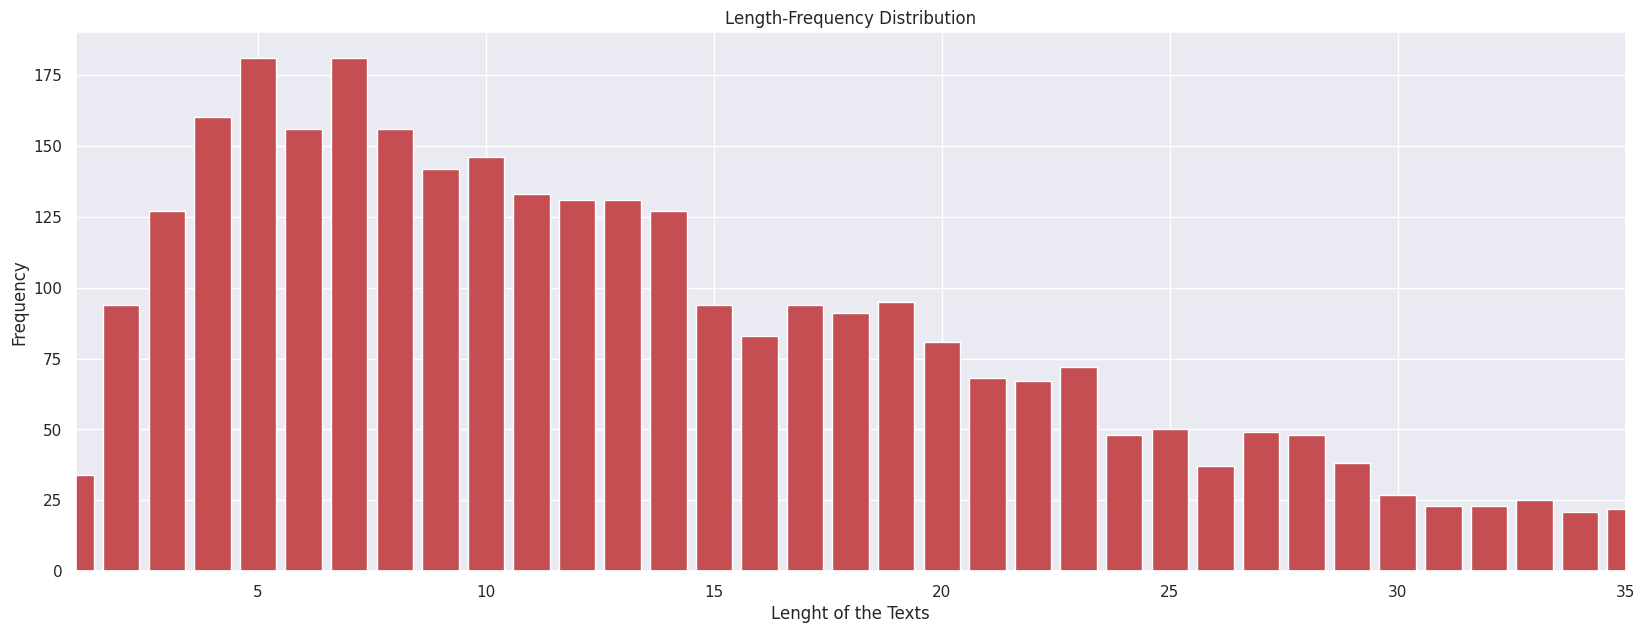

Maximum Length of a phrase: 505
Minimum Length of a phrase: 1
Average Length of a phrase: 16.0


In [ ]:
# Calculate the Review of each of the Review
dataSet['text_length'] = dataSet.text_cleaned.apply(lambda x:len(x.split()))

total_words = 0

frequency = dict()
for i in dataSet.text_length:
    frequency[i] = frequency.get(i, 0)+1

sns.set(rc={'figure.figsize':(20, 7)})
plt.bar(frequency.keys(), frequency.values(), color ="r")
plt.xlim(1, 35)
plt.xlabel('Lenght of the Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()

print(f"Maximum Length of a phrase: {max(dataSet.text_length)}")
print(f"Minimum Length of a phrase: {min(dataSet.text_length)}")
print(f"Average Length of a phrase: {round(np.mean(dataSet.text_length), 0)}")

In [ ]:
all_words = []
for sentence in dataSet.text_cleaned.apply(lambda x: x.split()):
    for word in sentence:
        all_words.append(word)

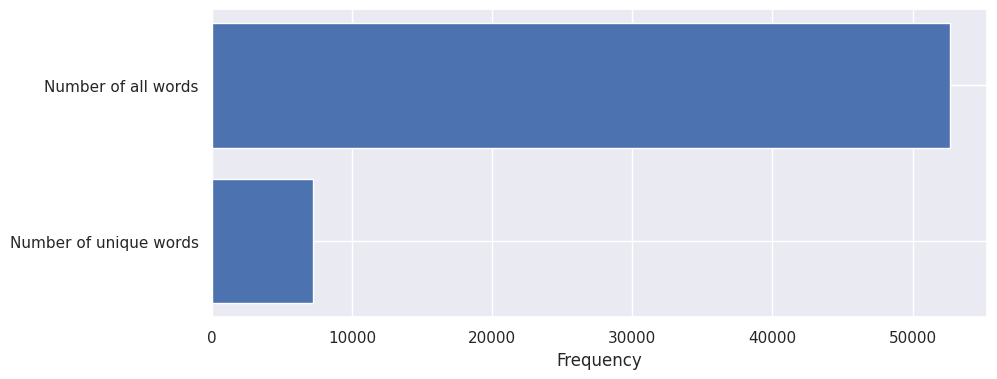

Total number of words:  52695
Total number of unique words:  7202


In [ ]:
freq_words = len(all_words)
freq_unique_words = len(set(all_words))

plt.figure(figsize = (10, 4))
plt.barh(['Number of unique words', 'Number of all words'], [freq_unique_words, freq_words])
plt.xlabel("Frequency")
plt.show()
print("Total number of words: ", freq_words)
print("Total number of unique words: ", freq_unique_words)

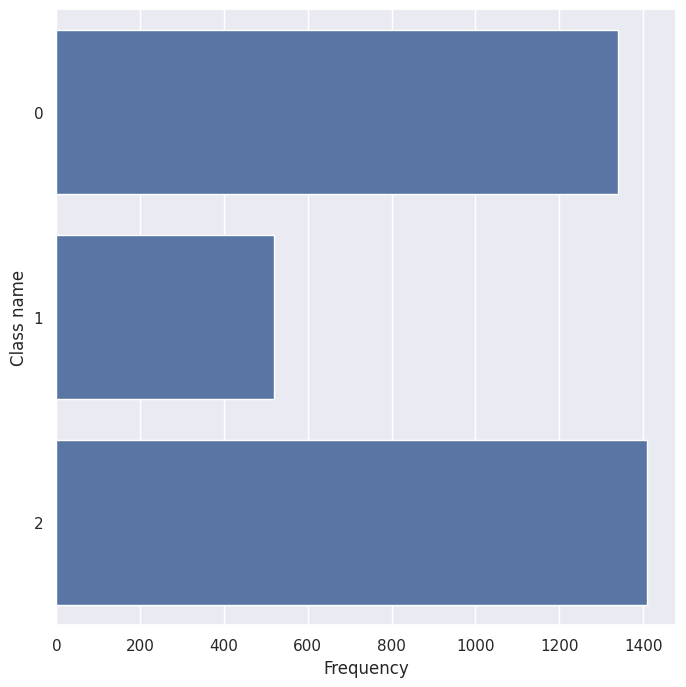

In [ ]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8, 8)})
promptsPlot = sns.countplot(y=dataSet['label'], data=dataSet)
# promptsPlot.bar_label(promptsPlot.containers[0])
promptsPlot.set(xlabel='Frequency', ylabel='Class name')
plt.show()

# Dropping unnecessary columns

In [ ]:
dataSet = dataSet.drop(['text', 'text_length'], axis=1)
dataSet.head(5)

,index,label,text_cleaned
0,0,2,যেমনটা আশা করছিলাম তেমনটাই দিয়েছেন
1,1,0,এক দোম ফালতু কেও নিবেন না
2,2,1,আলহামদুলিল্লাহ ভালো প্রডাক্ট এবং ভালো ভাবে পেয়...
3,3,1,আমার কাছে অসম্ভব সুন্দর লাগছে ছবির তুলনায় বাস্...
4,4,2,খুবই চমৎকার একটা ঘড়ি ধন্যবাদ


# Splitting dataset into train, test and valid

In [ ]:
X = dataSet['text_cleaned']
Y = dataSet['label']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=1, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.10, random_state=1, stratify=Y_train)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

print(Y_train.value_counts(normalize=True)*100)
print(Y_val.value_counts(normalize=True)*100)
print(Y_test.value_counts(normalize=True)*100)

(2499,)
(491,)
(278,)
2    43.097239
0    40.976391
1    15.926371
Name: label, dtype: float64
2    43.165468
0    41.007194
1    15.827338
Name: label, dtype: float64
2    43.177189
0    40.936864
1    15.885947
Name: label, dtype: float64


In [ ]:
train_df = pd.DataFrame({"text_cleaned": list(X_train), "Type": list(Y_train)})
test_df = pd.DataFrame({"text_cleaned": list(X_test), "Type": list(Y_test)})
validation_df = pd.DataFrame({"text_cleaned": list(X_val), "Type": list(Y_val)})

ds = DatasetDict()

ds['train'] = datasets.Dataset.from_pandas(train_df)
ds['test'] = datasets.Dataset.from_pandas(test_df)
ds['validation'] = datasets.Dataset.from_pandas(validation_df)

print(ds)

DatasetDict({
    train: Dataset({
        features: ['text_cleaned', 'Type'],
        num_rows: 2499
    })
    test: Dataset({
        features: ['text_cleaned', 'Type'],
        num_rows: 491
    })
    validation: Dataset({
        features: ['text_cleaned', 'Type'],
        num_rows: 278
    })
})


# Loading the pretrained model

In [ ]:
# checkpoint = 'neuralspace-reverie/indic-transformers-bn-bert'
checkpoint = 'csebuetnlp/banglabert'
# checkpoint = 'sagorsarker/bangla-bert-base'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
print(f"Vocab size is : {tokenizer.vocab_size}")

print(f"Model max length is : {tokenizer.model_max_length}")

print(f"Model input names are: {tokenizer.model_input_names}")

Vocab size is : 32000
Model max length is : 1000000000000000019884624838656
Model input names are: ['input_ids', 'token_type_ids', 'attention_mask']


# Tokenize each post

In [ ]:
def tokenize_function(train_dataset):
    return tokenizer(train_dataset['text_cleaned'], padding=True, truncation=True, max_length=100)

tokenized_dataset = ds.map(tokenize_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/2499 [00:00<?, ? examples/s]

Map:   0%|          | 0/491 [00:00<?, ? examples/s]

Map:   0%|          | 0/278 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text_cleaned', 'Type', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2499
    })
    test: Dataset({
        features: ['text_cleaned', 'Type', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 491
    })
    validation: Dataset({
        features: ['text_cleaned', 'Type', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 278
    })
})

In [ ]:
tokenized_dataset.set_format('torch', columns=["input_ids", "attention_mask", "Type"])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Split dataset into batches

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    tokenized_dataset['train'], shuffle=True, batch_size = 16, collate_fn = data_collator
)

test_loader = DataLoader(
    tokenized_dataset["test"], shuffle=False, batch_size=4, collate_fn=data_collator
)

validation_loader = DataLoader(
    tokenized_dataset['validation'], shuffle=True, batch_size=8, collate_fn=data_collator
)

# Creating the dictionary of train and validation dataset

In [ ]:
dataloaders = {"train" : train_loader,
               "val" : validation_loader}

# Model initialization

In [ ]:
class MyTaskSpecificCustomModel(nn.Module):
    def __init__(self, checkpoint, num_labels):
        super(MyTaskSpecificCustomModel, self).__init__()
        self.num_labels = num_labels

        self.model = AutoModel.from_pretrained(checkpoint, config = AutoConfig.from_pretrained(checkpoint,
                                                                                                       output_attention = True,
                                                                                                       output_hidden_state = True))

        # print('Freezing BERT layers')
        # for _ , param in self.model.named_parameters():
        #     param.requires_grad=False

        self.dropout = nn.Dropout(0.1)

        # New Layer
        #layer 1
        self.activation1 = nn.ReLU()
        self.l1 = nn.Linear(768, 500)

        #layer 2
        self.l2 = nn.Linear(500, 256)
        self.activation2 = nn.ReLU()

        #layer 3
        self.l3 = nn.Linear(256, 128)
        self.activation3 = nn.ReLU()


        #Output layer
        self.last = nn.Linear(128, num_labels)

    def forward(self, input_ids = None, attention_mask=None, Type = None):
        outputs = self.model(input_ids = input_ids, attention_mask = attention_mask)
        last_hidden_state = outputs[0]
        sequence_outputs = self.dropout(last_hidden_state)

        #layer 1
        logits = self.l1(sequence_outputs[:, 0, : ].view(-1, 768))
        logits = self.activation1(logits)

        #layer 2
        logits = self.l2(logits)
        logits = self.activation2(logits)

        #layer 3
        logits = self.l3(logits)
        logits = self.activation3(logits)

        #output layer
        logits = self.last(logits)

        return logits

In [ ]:
base_model = MyTaskSpecificCustomModel(checkpoint=checkpoint, num_labels=5).to(dml)
base_model

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

MyTaskSpecificCustomModel(
  (model): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm(

# Defining Hyperparameter

In [ ]:
num_classes = 5
num_epochs = 10
learning_rate = 1e-5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(base_model.parameters(), lr=learning_rate)

# Training the model

In [ ]:
validation_loss = []
training_loss = []

def train_model():
    since = time.time()
    val_acc_history = []

    best_model_wts = copy.deepcopy(base_model.state_dict())
    best_acc = 0.0

    progress_bar_train = tqdm(range(num_epochs * len(train_loader)))
    progress_bar_eval = tqdm(range(num_epochs * len(validation_loader)))

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                base_model.train()  # Set model to training mode
            else:
                base_model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch in dataloaders[phase]:
                batch = {k: v.to(dml) for k, v in batch.items()}

                # zero the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = base_model(**batch)
                    labels = batch['Type']

                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        progress_bar_train.update(1)
                    elif phase == 'val':
                        progress_bar_eval.update(1)

                running_loss += loss.item() * len(labels)
                preds = preds.cpu()
                labels = labels.data.cpu()
                running_corrects += (preds == labels).sum()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = float(running_corrects) / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                training_loss.append(epoch_loss)
            elif phase == 'val':
                validation_loss.append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(base_model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    base_model.load_state_dict(best_model_wts)
    return base_model, val_acc_history

In [ ]:
best_model, validation_acc_hist = train_model()

  0%|          | 0/1570 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

Epoch 0/9
----------
train Loss: 1.4488 Acc: 0.5074
val Loss: 1.1527 Acc: 0.7554

Epoch 1/9
----------
train Loss: 0.9353 Acc: 0.7723
val Loss: 0.7352 Acc: 0.7806

Epoch 2/9
----------
train Loss: 0.6386 Acc: 0.7891
val Loss: 0.6159 Acc: 0.7770

Epoch 3/9
----------
train Loss: 0.5109 Acc: 0.8267
val Loss: 0.5897 Acc: 0.7806

Epoch 4/9
----------
train Loss: 0.4123 Acc: 0.8888
val Loss: 0.5763 Acc: 0.8022

Epoch 5/9
----------
train Loss: 0.3493 Acc: 0.9024
val Loss: 0.6476 Acc: 0.8129

Epoch 6/9
----------
train Loss: 0.2812 Acc: 0.9284
val Loss: 0.6349 Acc: 0.8094

Epoch 7/9
----------
train Loss: 0.2433 Acc: 0.9376
val Loss: 0.6492 Acc: 0.8022

Epoch 8/9
----------
train Loss: 0.1984 Acc: 0.9524
val Loss: 0.7151 Acc: 0.8094

Epoch 9/9
----------
train Loss: 0.1982 Acc: 0.9492
val Loss: 0.7212 Acc: 0.8129

Training complete in 7m 28s
Best val Acc: 0.812950


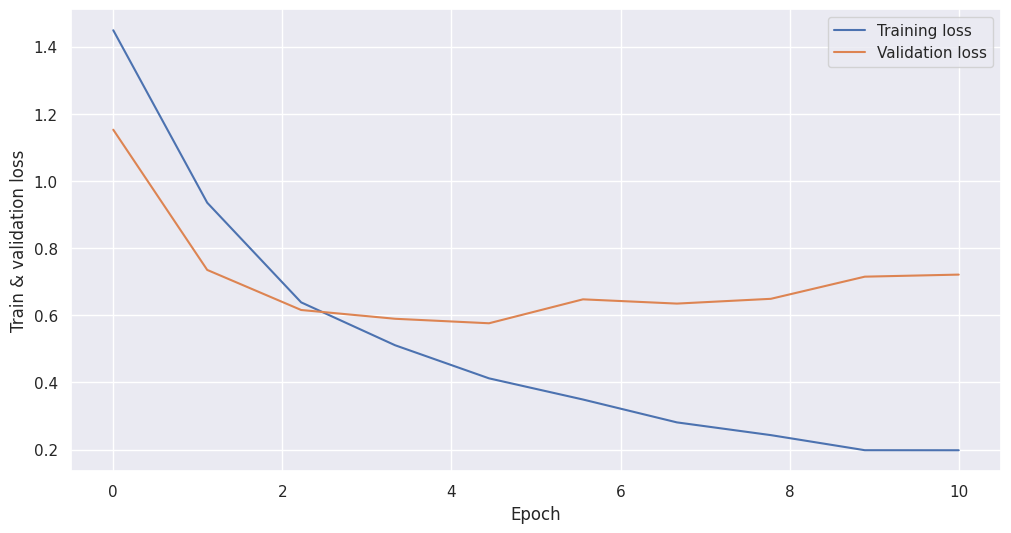

In [ ]:
x = torch.linspace(0, num_epochs, num_epochs)
plt.figure(figsize=(12,6))
plt.plot(x, training_loss)
plt.plot(x, validation_loss)
plt.legend(['Training loss','Validation loss'])
plt.xlabel("Epoch")
plt.ylabel("Train & validation loss")
plt.show()

In [ ]:
model_path = '/content/drive/MyDrive/Pattern/Hanjala/saveData.pt'
torch.save(best_model.state_dict(), model_path)

# Loading the saved model

In [ ]:
best_model = base_model
best_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# Testing the model using test dataset

In [ ]:
def get_predictions():
    best_model.eval()
    predictions = []
    real_values = []
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(dml) for k, v in batch.items()}

            outputs = base_model(**batch)
            labels = batch['Type']

            _, preds = torch.max(outputs, dim = 1)
            preds = preds.cpu()
            labels = labels.cpu()
            predictions.extend(preds)
            real_values.extend(labels)

    return predictions, real_values

In [ ]:
pred, real = get_predictions()
print(classification_report([y_actual.item() for y_actual in real], [y_pred.item() for y_pred in pred]))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86       201
           1       0.55      0.46      0.50        78
           2       0.82      0.88      0.85       212

    accuracy                           0.81       491
   macro avg       0.75      0.73      0.74       491
weighted avg       0.80      0.81      0.80       491



In [ ]:
def score_in_details():
    y_pred = [y.item() for y in pred]
    y_real = [y.item() for y in real]

    accuracy = accuracy_score(y_real, y_pred)
    precision = precision_score(y_real, y_pred, average='macro')
    recall = recall_score(y_real, y_pred, average='macro')
    f1 = f1_score(y_real, y_pred, average='macro')

    print(f"Accuracy: {round(accuracy * 100, 2)}%")
    print(f"Precision: {precision}%")
    print(f"Recall: {recall}%")
    print(f"F1-score: {f1}%")

    print()
    print()

    conf_matrix = confusion_matrix(y_real, y_pred)

    fig, ax = plt.subplots(figsize=(7,7))
    sns.heatmap(pd.DataFrame(conf_matrix), annot = True, cmap = 'YlGnBu',fmt = 'g')
    plt.title('Confusion matrix', fontsize=10)
    plt.ylabel('Actual label', fontsize=10)
    plt.xlabel('Predicted label', fontsize=10)
    plt.show()

Accuracy: 80.65%
Precision: 0.7489938112566673%
Recall: 0.7347701502165034%
F1-score: 0.7401442407251063%




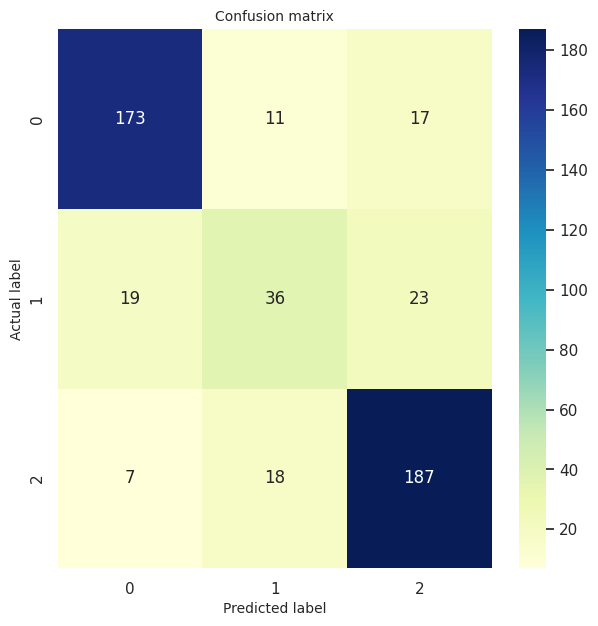

In [ ]:
score_in_details()